In [71]:
#%% Mount Google drive if you use colab for save and load LSTM models
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/01_Emulation/MPC_emulation/FOPDT/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression


from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pickle import dump, load
import joblib
import time

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

In [73]:
data1 = pd.read_pickle(path + 'closed_loop_data_1200.pkl')
data2 = pd.read_pickle(path + 'closed_loop_data_1300.pkl')
data1 = np.array(data1)
data2 = np.array(data2)

data1 = data1.transpose()
data2 = data2.transpose()

df1 = pd.DataFrame(data1,columns=['u1','u2','y1','y2','SP1','SP2'])
df2 = pd.DataFrame(data2,columns=['u1','u2','y1','y2','SP1','SP2'])

df = pd.concat([df1,df2])
df = df.reset_index()
df = df.drop(df.columns[0], axis=1)

# df['SP1'][0:-1] = df['SP1'][1:]
# df['SP2'][0:-1] = df['SP2'][1:]

# df['u1'].shift(1)).fillna(method='bfill', inplace=True)
# df['u2'].shift(1)).fillna(method='bfill', inplace=True)
# df['y1'].shift(2)).fillna(method='bfill', inplace=True)
# df['y2'].shift(2)).fillna(method='bfill', inplace=True)

print(df.shift(1).fillna(method='bfill', inplace=True))
df[['u1', 'u2']] = df[['u1', 'u2']].shift(1)
df[['y1', 'y2']] = df[['y1', 'y2']].shift(2)
df.fillna(method='bfill', inplace=True)
print(df)
# print(df.head())

None
            u1        u2        y1        y2       SP1       SP2
0     0.000000  0.287500  0.164375  0.457500  0.000000  0.000000
1     0.000000  0.287500  0.164375  0.457500  0.000000  0.000000
2     0.000000  0.000000  0.164375  0.457500  0.000000  0.000000
3     0.000000  0.000000  0.082187  0.228750  0.000000  0.000000
4     0.000000  0.000000  0.041094  0.114375  0.000000  0.000000
...        ...       ...       ...       ...       ...       ...
2495  1.569496  0.450334  0.609846  0.391950  0.652107  0.334419
2496  1.545784  0.431445  0.641339  0.364517  0.652107  0.334419
2497  1.530791  0.436730  0.651399  0.345837  0.652107  0.334419
2498  1.522685  0.445760  0.653694  0.336804  0.652107  0.334419
2499  1.518656  0.452184  0.653672  0.333688  0.652107  0.334419

[2500 rows x 6 columns]


In [74]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=df.SP1,name="SP1"), row=1, col=1)
fig.add_trace(go.Scatter(y=df.SP2,name="SP2"), row=1, col=1)
fig.add_trace(go.Scatter(y=df.y1,name="y1"), row=1, col=1)
fig.add_trace(go.Scatter(y=df.y2,name="y2"), row=1, col=1)
fig.add_trace(go.Scatter(y=df.u1,name="u1"), row=2, col=1)
fig.add_trace(go.Scatter(y=df.u2,name="u2"), row=2, col=1)

fig.update_layout(
    template="plotly_white",
    font_family="Times New Roman",
    font_size = 20
    )

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, row=1 , col=1)
fig.update_xaxes(title_text='Time',showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.update_yaxes(title_text='y', showline=True, linewidth=2, linecolor='black', mirror=True, row=1, col=1)
fig.update_yaxes(title_text='u', showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.show()

In [75]:
df['err1'] = df['SP1'] - df['y1']
df['err2'] = df['SP2'] - df['y2']
print(df.head())

    u1      u2        y1        y2  SP1  SP2      err1      err2
0  0.0  0.2875  0.164375  0.457500  0.0  0.0 -0.164375 -0.457500
1  0.0  0.2875  0.164375  0.457500  0.0  0.0 -0.164375 -0.457500
2  0.0  0.0000  0.164375  0.457500  0.0  0.0 -0.164375 -0.457500
3  0.0  0.0000  0.082187  0.228750  0.0  0.0 -0.082187 -0.228750
4  0.0  0.0000  0.041094  0.114375  0.0  0.0 -0.041094 -0.114375


Text(0.5, 1.0, 'u2 feature selection')

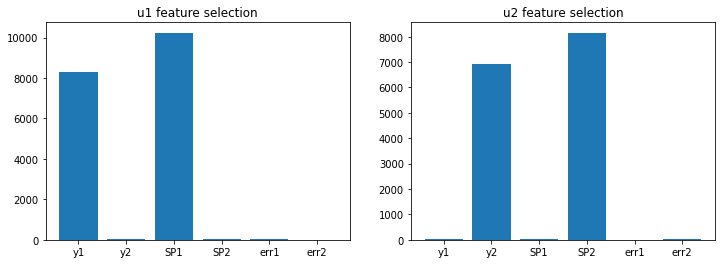

In [76]:
# Feature selection
# Determine input and output values for model 
features = df[['y1','y2','SP1','SP2','err1','err2']]
label1 = np.ravel(df[['u1']])
label2 = np.ravel(df[['u2']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')

# Best features for Q1
fit1 = bestfeatures.fit(features,label1)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.bar(x=features.columns,height=fit1.scores_)
plt.title('u1 feature selection')

# Best features for Q2
fit2 = bestfeatures.fit(features,label2)
plt.subplot(122)
plt.bar(x=features.columns,height=fit2.scores_)
plt.title('u2 feature selection')

# plt.savefig(path + 'K-best_FOPDT_MPC.eps', format='eps')

In [77]:
df = df.drop(df.columns[6:8], axis=1)
print(df.head())

    u1      u2        y1        y2  SP1  SP2
0  0.0  0.2875  0.164375  0.457500  0.0  0.0
1  0.0  0.2875  0.164375  0.457500  0.0  0.0
2  0.0  0.0000  0.164375  0.457500  0.0  0.0
3  0.0  0.0000  0.082187  0.228750  0.0  0.0
4  0.0  0.0000  0.041094  0.114375  0.0  0.0


In [78]:
s_x = MinMaxScaler(feature_range=(-1,1))
Xs = s_x.fit_transform(df[['y1','y2','SP1','SP2']])
s_y = MinMaxScaler(feature_range=(-1,1))
Ys = s_y.fit_transform(df[['u1','u2']])

In [79]:
window = 10

X = []
Y = []
for i in range(window,len(Xs)):
    X.append(Xs[i-window:i,:])
    # X.append(Xs1[i-window:i])
    Y.append(Ys[i])


# Reshape data to format accepted by LSTM
X, Y = np.array(X), np.array(Y)

In [80]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s_x
model_params['yscale'] = s_y
model_params['window'] = window

# dump(model_params, open(path + 'model_param.pkl', 'wb'))

In [81]:
# Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=2)) #units = number of outputs
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='val_loss',restore_best_weights=True, mode='min',verbose=1,patience=20)

In [82]:
# Fit (and time) LSTM model
t0 = time.time()
result_lstm = model_lstm.fit(X, Y, epochs = 300, batch_size = 250, callbacks=[es_lstm, TqdmCallback(verbose=1)],\
                             verbose=0, validation_split=0.2)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))


# model_lstm.save(path + 'MPC_emulate_LSTM.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00150: early stopping
Runtime: 14.15 s


In [83]:
m = X.shape[2]

encoder_input = tf.keras.layers.Input(shape=(window, m))
xl = tf.keras.layers.MultiHeadAttention(num_heads=4,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(m, None)(xl)
# hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

# hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
# res = hl_mha + encoder_input
# hl_mha = tf.keras.layers.Dense(10, 'tanh')(res)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*m, activation="relu")(res)
# hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
# hl_mha = tf.keras.layers.Dense(m, None)(hl_mha)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# # hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

# hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
# res = hl_mha + encoder_input
# hl_mha = tf.keras.layers.Dense(10, 'tanh')(res)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*m, activation="relu")(res)
# hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
# hl_mha = tf.keras.layers.Dense(m, None)(hl_mha)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# # hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

# hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
# res = hl_mha + encoder_input
# hl_mha = tf.keras.layers.Dense(10, 'tanh')(res)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*m, activation="relu")(res)
# hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
# hl_mha = tf.keras.layers.Dense(m, None)(hl_mha)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# # hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

# hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
# res = hl_mha + encoder_input
# hl_mha = tf.keras.layers.Dense(10, 'tanh')(res)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*m, activation="relu")(res)
# hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
# hl_mha = tf.keras.layers.Dense(m, None)(hl_mha)
# # hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# # hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)


# hl_mha = tf.keras.layers.Dense(5, activation='relu')(hl_mha)
# hl_mha = tf.keras.layers.Dense(3, activation=None)(hl_mha)
xl = tf.keras.layers.Flatten()(xl)
yl = tf.keras.layers.Dense(2, activation='linear')(xl)
model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")

model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

es_trans = EarlyStopping(monitor='val_loss',restore_best_weights=True, mode='min',verbose=1,patience=10)

t0 = time.time()
result_trans = model_trans.fit(X,Y,epochs=300,batch_size=32, validation_split=0.5, callbacks=[es_trans, TqdmCallback(verbose=1)], verbose=0)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

# model_trans.save(path + 'MPC_emulate_Transformer.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
Runtime: 20.54 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


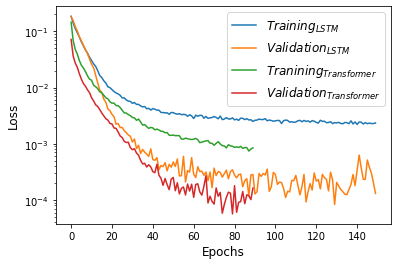

In [84]:
# Show Loss function and save
epochs = es_lstm.stopped_epoch
plt.semilogy(result_lstm.history['loss'],label='$Training_{LSTM}$')
plt.semilogy(result_lstm.history['val_loss'],label='$Validation_{LSTM}$')
plt.semilogy(result_trans.history['loss'],label='$Tranining_{Transformer}$')
plt.semilogy(result_trans.history['val_loss'],label='$Validation_{Transformer}$')
plt.legend(loc=1, fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

plt.savefig(path + 'Loss_LSTM_Transformer_MPC_FOPDT.eps', format='eps')

## Model Validation (One step ahead prediction)

In [64]:
# Load models
model_lstm = load_model(path + 'MPC_emulate_LSTM.h5')
model_trans = load_model(path + 'MPC_emulate_Transformer.h5')

In [65]:
# Verify the fit of the model (LSTM)
Yp_lstm = model_lstm.predict(X)
Xp_lstm = Xs
Xp_lstm = s_x.inverse_transform(Xp_lstm)
Yp_lstm = s_y.inverse_transform(Yp_lstm)

In [66]:
# Verify the fit of the model (Transformer)
Yp_trans = model_trans.predict(X)
Xp_trans = Xs
Xp_trans = s_x.inverse_transform(Xp_trans)
Yp_trans = s_y.inverse_transform(Yp_trans)

In [67]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=Yp_lstm[:, 0],name="LSTM"), row=1, col=1)
fig.add_trace(go.Scatter(y=Yp_trans[:, 0],name="Transformer"), row=1, col=1)
fig.add_trace(go.Scatter(y=df.u1[window:],name="Meas"), row=1, col=1)
fig.add_trace(go.Scatter(y=Yp_lstm[:, 1],name="LSTM"), row=2, col=1)
fig.add_trace(go.Scatter(y=Yp_trans[:, 1],name="Transformer"), row=2, col=1)
fig.add_trace(go.Scatter(y=df.u2[window:],name="Meas"), row=2, col=1)

fig.update_layout(
    template="plotly_white",
    font_family="Times New Roman",
    font_size = 20
    )

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, row=1 , col=1)
fig.update_xaxes(title_text='Time',showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.update_yaxes(title_text='u1', showline=True, linewidth=2, linecolor='black', mirror=True, row=1, col=1)
fig.update_yaxes(title_text='u2', showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.show()

## Model Validation (Multistep prediction with very first window data)

In [68]:
# LSTM

P = 1000

yh = []
x0 = X[:1]
# x0 = x0[newaxis,:, :]
n_x = len(Y[0])
yh_i = model_lstm(x0)
yh.extend(yh_i)

for i_step in range(1, P-window):
    x0[0][:-1] = x0[0][1:]
    # x0[0][-1] = concatenate((yh_i[0], self.x[i_step][-1][n_x:]))
    x0[0][-1] = np.hstack((yh_i[0],X[i_step][-1][n_x:]))
    # a_temp = list(yh_i[0]) + list(self.x[i_step][-1][n_x:])
    # x0[0][-1] = a_temp
    # x0[0][-1] = hstack((self.x[i_step][-1][:n_x], self.x[i_step][-1][n_x:]))

    yh_i = model_lstm(x0)
    yh.extend(yh_i)

df_yh = pd.DataFrame(yh)
# signal.time_h = np.concat([signal.time, signal.yh], axis=1, join='inner')[0]
# signal.time = signal.time.iloc[self.timesteps:]

y_lstm = s_y.inverse_transform(df_yh)

In [69]:
# Transformer

P = 1000

yh = []
x0 = X[:1]
# x0 = x0[newaxis,:, :]
n_x = len(Y[0])
yh_i = model_trans(x0)
yh.extend(yh_i)

for i_step in range(1, P-window):
    x0[0][:-1] = x0[0][1:]
    # x0[0][-1] = concatenate((yh_i[0], self.x[i_step][-1][n_x:]))
    x0[0][-1] = np.hstack((yh_i[0],X[i_step][-1][n_x:]))
    # a_temp = list(yh_i[0]) + list(self.x[i_step][-1][n_x:])
    # x0[0][-1] = a_temp
    # x0[0][-1] = hstack((self.x[i_step][-1][:n_x], self.x[i_step][-1][n_x:]))

    yh_i = model_trans(x0)
    yh.extend(yh_i)

df_yh = pd.DataFrame(yh)
# signal.time_h = np.concat([signal.time, signal.yh], axis=1, join='inner')[0]
# signal.time = signal.time.iloc[self.timesteps:]

y_trans = s_y.inverse_transform(df_yh)


In [70]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=y_lstm[:, 0],name="LSTM"), row=1, col=1)
fig.add_trace(go.Scatter(y=y_trans[:, 0],name="Transformer"), row=1, col=1)
fig.add_trace(go.Scatter(y=df.u1[window:P],name="Meas"), row=1, col=1)
fig.add_trace(go.Scatter(y=y_lstm[:, 1],name="LSTM"), row=2, col=1)
fig.add_trace(go.Scatter(y=y_trans[:, 1],name="Transformer"), row=2, col=1)
fig.add_trace(go.Scatter(y=df.u2[window:P],name="Meas"), row=2, col=1)

fig.update_layout(
    template="plotly_white",
    font_family="Times New Roman",
    font_size = 20
    )

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, row=1 , col=1)
fig.update_xaxes(title_text='Time',showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.update_yaxes(title_text='u1', showline=True, linewidth=2, linecolor='black', mirror=True, row=1, col=1)
fig.update_yaxes(title_text='u2', showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.show()